In [127]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

RANDOM_SEED = 42

# Specify each path

In [ ]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Step 1: Load the model from the .hdf5 file
model = load_model("model/keypoint_classifier/keypoint_classifier.keras")

# Step 2: Save the model in the .keras format
model.save("model/keypoint_classifier/keypoint_classifier.keras")

# Set number of classes

In [ ]:
NUM_CLASSES = 8

# Dataset reading

In [130]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [131]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [133]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [134]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_22 (Dropout)            │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,180 (4.61 KB)

 Trainable params: 1,180 (4.61 KB)

 Non-trainable params: 0 (0.00 B)

In [135]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [136]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [137]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 7s 789ms/step - accuracy: 0.0469 - loss: 2.5426
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0941 - loss: 2.4248 - val_accuracy: 0.1077 - val_loss: 2.2466
Epoch 2/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1719 - loss: 2.2624
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1524 - loss: 2.2560 - val_accuracy: 0.2178 - val_loss: 2.1379
Epoch 3/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2188 - loss: 2.1610
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2084 - loss: 2.1512 - val_accuracy: 0.2600 - val_loss: 2.0475
Epoch 4/1000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1875 - loss: 2.1046
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.ker

In [138]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0384 


In [139]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [140]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[8.4386143e-09 5.9405393e-06 2.1111439e-10 9.9993777e-01 2.4281546e-11
 1.1629052e-06 6.1104271e-07 5.4479638e-05 2.5511536e-14 5.1770628e-12]
3


# Confusion matrix

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step


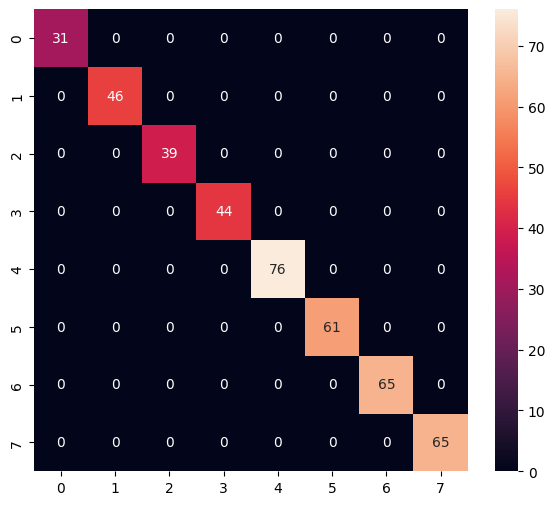

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        46
           2       1.00      1.00      1.00        39
           3       1.00      1.00      1.00        44
           4       1.00      1.00      1.00        76
           5       1.00      1.00      1.00        61
           6       1.00      1.00      1.00        65
           7       1.00      1.00      1.00        65

    accuracy                           1.00       427
   macro avg       1.00      1.00      1.00       427
weighted avg       1.00      1.00      1.00       427



In [141]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [142]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [143]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\dteh6\AppData\Local\Temp\tmp4lyjwyta\assets


INFO:tensorflow:Assets written to: C:\Users\dteh6\AppData\Local\Temp\tmp4lyjwyta\assets


Saved artifact at 'C:\Users\dteh6\AppData\Local\Temp\tmp4lyjwyta'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_11')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2164770869648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2164770874256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2164770875024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2164770871952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2164770880784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2164770880016: TensorSpec(shape=(), dtype=tf.resource, name=None)


6836

# Inference test

In [144]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [145]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [146]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [147]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [148]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.4386143e-09 5.9405502e-06 2.1111479e-10 9.9993777e-01 2.4281546e-11
 1.1629052e-06 6.1104271e-07 5.4479638e-05 2.5511535e-14 5.1770623e-12]
3
